# AutoML Training Pipeline

!python -m pip install --upgrade pip
!pip install kfp==1.4.0
!pip install kubeflow-katib==0.11.0
!pip install kfp-tekton==0.7.0
!pip install kubernetes==12.0.0

In [45]:
import kfp
import json
import kfp.dsl as dsl
from kfp import components

from kubeflow.katib import ApiClient
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1EarlyStoppingSpec
from kubeflow.katib import V1beta1EarlyStoppingSetting
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

from kubeflow.katib import KatibClient
from kubernetes.client import V1ObjectMeta
from kubeflow.katib import V1beta1Experiment
from kubeflow.katib import V1beta1AlgorithmSpec
from kubeflow.katib import V1beta1AlgorithmSetting
from kubeflow.katib import V1beta1ObjectiveSpec
from kubeflow.katib import V1beta1MetricsCollectorSpec
from kubeflow.katib import V1beta1CollectorSpec
from kubeflow.katib import V1beta1SourceSpec
from kubeflow.katib import V1beta1FilterSpec
from kubeflow.katib import V1beta1FeasibleSpace
from kubeflow.katib import V1beta1ExperimentSpec
from kubeflow.katib import V1beta1NasConfig
from kubeflow.katib import V1beta1GraphConfig
from kubeflow.katib import V1beta1Operation
from kubeflow.katib import V1beta1ParameterSpec
from kubeflow.katib import V1beta1TrialTemplate
from kubeflow.katib import V1beta1TrialParameterSpec

In [78]:


# Trial count specification.
max_trial_count = 2
max_failed_trial_count = 3
parallel_trial_count = 2

# Objective specification.
objective=V1beta1ObjectiveSpec(
    type="maximize",
    goal= 0.95,
    objective_metric_name="val_accuracy",
    additional_metric_names=[
        "loss","accuracy"
    ]
)

# Algorithm specification.
algorithm=V1beta1AlgorithmSpec(
    algorithm_name="random" ,#"bayesianoptimization",
)

# Early Stopping specification.
early_stopping=V1beta1EarlyStoppingSpec(
    algorithm_name="medianstop",
    algorithm_settings=[
        V1beta1EarlyStoppingSetting(
            name="min_trials_required",
            value="2"
        )
    ]
)

metrics_collector_spec=V1beta1MetricsCollectorSpec(
collector=V1beta1CollectorSpec(kind="StdOut"))

# Experiment search space.
# In this example we tune learning rate, number of layer and optimizer.
# Learning rate has bad feasible space to show more early stopped Trials.
parameters=[
    V1beta1ParameterSpec(
        name="learning-rate",
        parameter_type="double",
        feasible_space=V1beta1FeasibleSpace(
            min="0.0001",
            max="0.00015"
        ),
    ),
    V1beta1ParameterSpec(
        name="optimizer",
        parameter_type="categorical",
        feasible_space=V1beta1FeasibleSpace(
            list=[
                "SGD", 
                "ADAM",
                "RMSprop"
            ]
        ),
    ),
     V1beta1ParameterSpec(
        name="drop-out",
        parameter_type="double",
        feasible_space=V1beta1FeasibleSpace(
            min="0.15",
            max="0.25"
        ),
    ),
    
    
]

In [79]:
# JSON template specification for the Trial's Worker Kubernetes Job.
trial_spec={
    "apiVersion": "batch/v1",
    "kind": "Job",
    "spec": {
        "template": {
            "metadata": {
                "annotations": {
                     "sidecar.istio.io/inject": "false"
                }
            },
            "spec": {
                "containers": [
                    {
                        "name": "training-container",
                        "image": "gcr.io/<PROJECT_ID>/kubeflow/hpo:v5",
                        "command": [
                            "python3",
                            "/opt/model.py",
                            "--learning-rate=${trialParameters.learningRate}",
                            "--optimizer=${trialParameters.optimizer}"
                            "--drop-out=${trialParameters.dropOut}"
                            
                    
                        ]
                    }
                ],
                "restartPolicy": "Never"
            }
        }
    }
}

# Configure parameters for the Trial template.
# We set the retain parameter to "True" to not clean-up the Trial Job's Kubernetes Pods.
trial_template=V1beta1TrialTemplate(
    retain=True,
    primary_container_name="training-container",
    trial_parameters=[
        V1beta1TrialParameterSpec(
            name="learningRate",
            description="Learning rate for the training model",
            reference="learning-rate"
        ),
         V1beta1TrialParameterSpec(
            name="dropOut",
            description="Drop out of training model layers",
            reference="drop-out"
        ),
        V1beta1TrialParameterSpec(
            name="optimizer",
            description="Training model optimizer (sdg, adam or rmsprop)",
            reference="optimizer"
        ),
      
      
    ],
    trial_spec=trial_spec
)

In [80]:
experiment_spec=V1beta1ExperimentSpec(
    max_trial_count=max_trial_count,
    max_failed_trial_count=max_failed_trial_count,
    parallel_trial_count=parallel_trial_count,
    objective=objective,
    algorithm=algorithm,
    early_stopping=early_stopping,
     metrics_collector_spec=metrics_collector_spec,
    parameters=parameters,
    trial_template=trial_template
)

In [81]:
# Get the Katib launcher.
katib_experiment_launcher_op = components.load_component_from_url(
    "https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml")
import kfp.gcp as gcp
from kfp import components
import kfp.dsl as dsl
from string import Template

def convert_result(experiment_result) -> str:
    import json
    r = json.loads(experiment_result)
    print(type(r))
    print(r)
    #args = []
    #for hp in r['currentOptimalTrial']['parameterAssignments']:
     #   print(hp)
      #  args.append("%s:%s," % (hp["name"], hp["value"]))     
    args={}
    for hp in r['currentOptimalTrial']['parameterAssignments']:
            z=hp["value"]
            args[f'{hp["name"]}']=f"{z}"

    
    return str(args)

def set_resources(memory_req=None, memory_lim=None, cpu_req=None, cpu_lim=None, gpus="0", container:dsl.ContainerOp.container=None):
    if container:
        container.set_memory_request(memory_req)
        container.set_memory_limit(memory_lim)
        container.set_cpu_request(cpu_req)
        container.set_cpu_limit(cpu_lim)
        if int(gpus) > 0:
            container.set_gpu_limit(gpus)
        return container
    else:
        return None

@dsl.pipeline(
    name="Launch Katib early stopping Experiment",
    description="An example to launch Katib Experiment with early stopping"
)
def community_pipeline(experiment_name = "katib-pipes",experiment_namespace = "<USER_NAMESPACE>",tensorboard_gcs_logs="gs://<BUCKET>/imageclassfication/logs",
                       mode="GCS",gcs_path="gs://<BUCKET>/imageclassfication/model",train_image="gcr.io/<PROJECT_ID>/kubeflow/train:v1",seving_image="gcr.io/<PROJECT_ID>/kubeflow/serving:v1"):
    
    
    vop = dsl.VolumeOp(
      name='my-pvc',
      resource_name="my-pvc",
      modes=dsl.VOLUME_MODE_RWO,
      size="1Gi"
    )
    
    
    # Katib launcher component.
    # Experiment Spec should be serialized to a valid Kubernetes object.
    op = katib_experiment_launcher_op(
        experiment_name=experiment_name,
        experiment_namespace=experiment_namespace,
        experiment_spec=ApiClient().sanitize_for_serialization(experiment_spec),
        experiment_timeout_minutes=240,
        delete_finished_experiment=False).after(vop)
    
    # Output container to print the results.
    '''
    op_out = dsl.ContainerOp(
        name="best-hp",
        image="library/bash:4.4.23",
        command=["sh", "-c"],
        arguments=["echo Best HyperParameters: %s" % op.output],
    )
    '''
    set_resources(memory_req="4Gi", memory_lim="6Gi", cpu_req="2", cpu_lim="4", container=op.container)
    
    convert_op = components.func_to_container_op(convert_result)
    op2 = convert_op(op.output)
    
    
    train_step = dsl.ContainerOp(
        name='train_best_params',
        image=train_image, 
        command="python",
        arguments=[
            "/app/train.py",
            "--artifacts",op2.output,
            "--tensorboard-gcs-logs",tensorboard_gcs_logs,
            "--gcs-path",gcs_path,
            "--mode",mode],file_outputs={"mlpipeline-ui-metadata": "/mlpipeline-ui-metadata.json"
        },pvolumes={"/mnt": op.pvolume})
    
    template=Template("""
                {
               "apiVersion": "serving.kubeflow.org/v1alpha2",
               "kind": "InferenceService",
               "metadata": {
                  "labels": {
                     "controller-tools.k8s.io": "1.0"
                  },
                  "name": "kfserving-vision-realtime",
                  "namespace": "$namespace",
                  "annotations": {
                     "sidecar.istio.io/inject": "false"
                  }
               },
               "spec": {
                  "default": {
                     "predictor": {
                        "minReplicas": 1,
                        "custom": {
                           "container": {
                              "name": "kfserving-container",
                              "image": "$servingimage",
                              "env": [
                                 {
                                    "name": "STORAGE_URI",
                                    "value": "$bucket"
                                 }
                              ],
                              "imagePullPolicy": "Always"
                           }
                        }
                     }
                  }
               }
            }
    
    
    """)
    tensorjson = template.substitute({ 'bucket': str(gcs_path),'namespace': str(experiment_namespace),'servingimage': str(seving_image)})

    deployment = json.loads(tensorjson)

    deploy = dsl.ResourceOp(
        name="deploy",
        k8s_resource=deployment,
        action="apply",
        success_condition='status.url' #'status.state == Available'
    )
    deploy.after(train_step)
    
if __name__ == '__main__':
    import kfp.compiler as compiler
    pipeline_func = community_pipeline
    pipeline_filename = pipeline_func.__name__ + '.pipeline.yaml'
    compiler.Compiler().compile(pipeline_func,pipeline_filename)

In [82]:
import kfp
client=kfp.Client()

In [21]:
experiment = client.create_experiment(name='RealtimeKubeflow' ,description='Run the Pipeline', namespace='<USER_NAMESPACE>')

In [50]:
experiment

{'created_at': datetime.datetime(2021, 7, 15, 19, 58, 19, tzinfo=tzlocal()),
 'description': 'Run the Pipeline',
 'id': '867cf3c9-e8a2-407b-908f-9f57f9e17891',
 'name': 'RealtimeKubeflow',
 'resource_references': [{'key': {'id': 'aniruddha-choudhury',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

In [91]:
filepath = '/home/jovyan/lost+found/community_pipeline.pipeline.yaml'
name= 'imageclassfication'
pipeline = client.pipeline_uploads.upload_pipeline(filepath, name=name)


In [92]:
params={'experiment_name' : "katib-automl",'experiment_namespace' : "USER_NAMESPACE",'tensorboard_gcs_logs':"gs://<BUCKET>/imageclassfication/logs",
                       'mode':"GCS",'gcs_path': "gs://<BUCKET>/imageclassfication/model",'train_image':"gcr.io/<PROJECT_ID>/kubeflow/train:v1",'seving_image':"gcr.io/<PROJECT_ID>/kubeflow/serving:v1"}

In [93]:
run_pipeline = client.run_pipeline(job_name='AutoMLrunimage' ,experiment_id=experiment.id,params=params,pipeline_id=pipeline1.id)


# Serving

In [32]:
import json
import base64
import requests
from PIL import Image
from io import BytesIO

In [33]:
def predict_object_detection(data, host,session, url):
    headers = {}
    headers["Host"] = host
    cookies = None
    if session != "":
        cookies = {'authservice_session': session}
    #print(url, headers, cookies)
    res = requests.post(url, json=data, headers=headers,cookies=cookies, verify=False)
    if res.status_code == 200:
        return res.json()
    else:
        return "Status code : {0}".format(res.status_code)

In [34]:
session=""
host='kfserving-vision-realtime.default.svc.cluster.local'
url='http://kfserving-vision-realtime.default.svc.cluster.local/v1/models/kfserving-vision-realtime:predict'

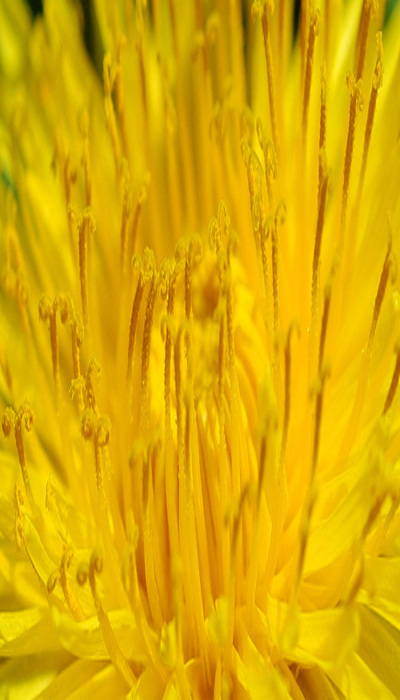

Flower name tulips


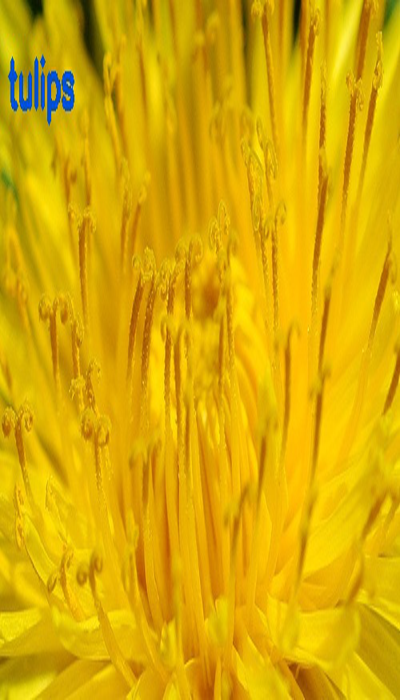

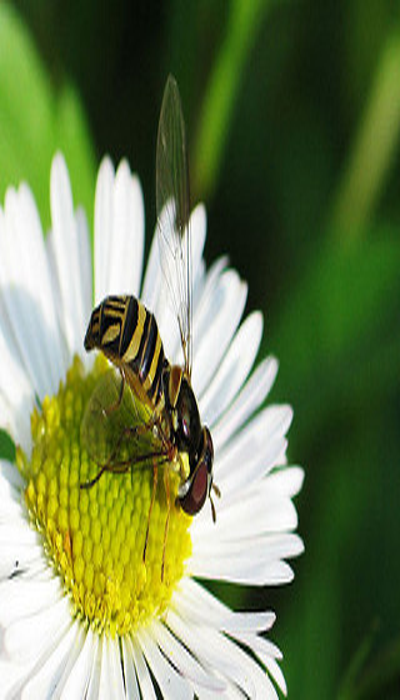

Flower name dandelion


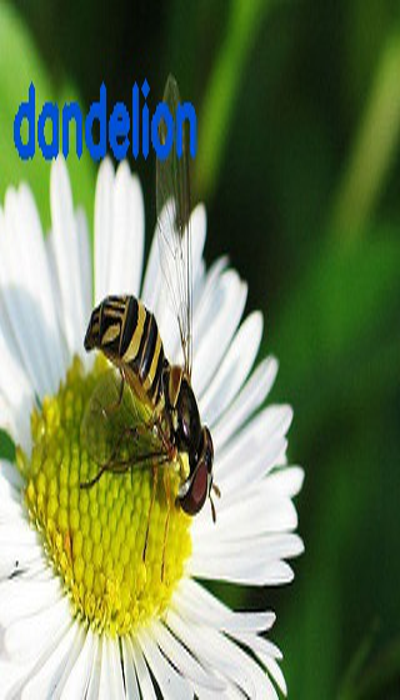

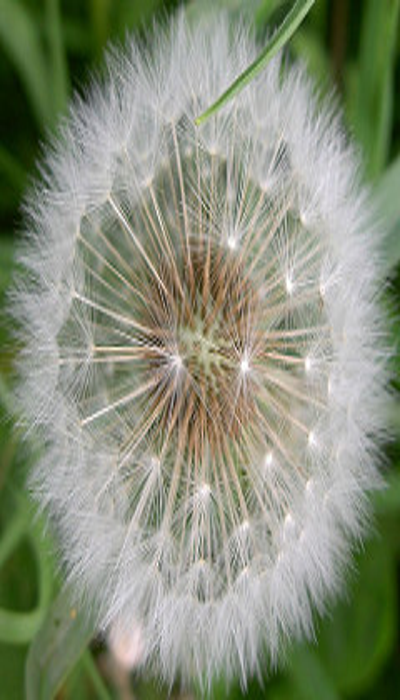

Flower name dandelion


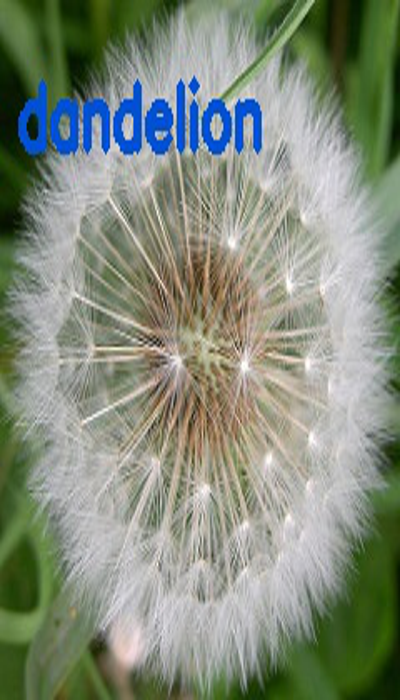

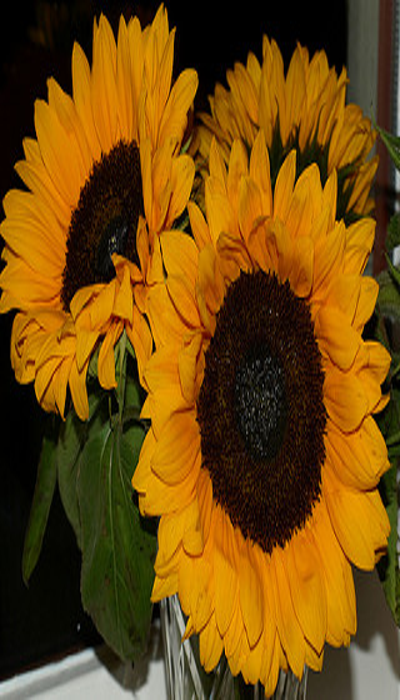

Flower name tulips


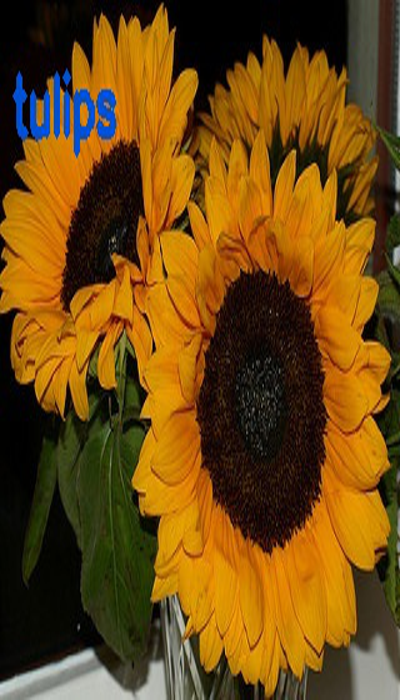

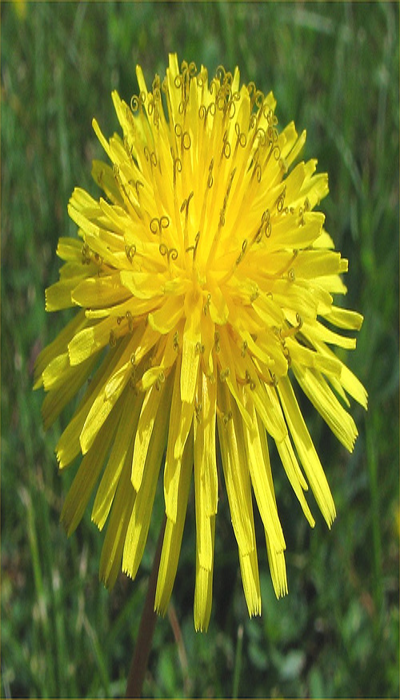

Flower name dandelion


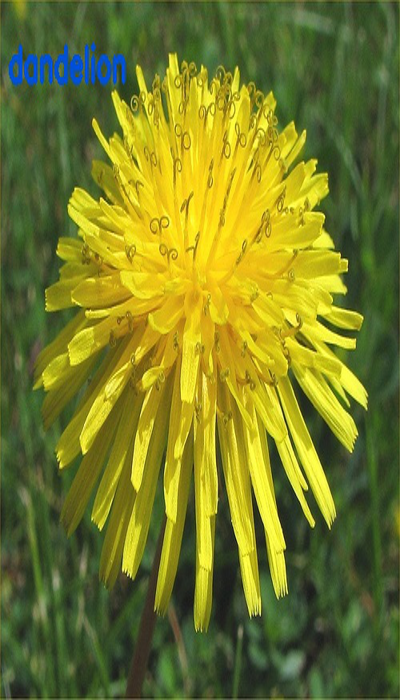

In [96]:
NUM_SAMPLES=5
for index in range(NUM_SAMPLES):
    samples=[]
    with open(f"/home/jovyan/lost+found/image/flower{index + 1}.jpg", "rb") as image_file:
        encoded_bytes = base64.b64encode(image_file.read())
        # ressult: string (in utf-8)
        encoded_string = encoded_bytes.decode('utf-8')
        samples.append(encoded_string)
        #print("Brain Scan Image")
        img = Image.open(image_file).resize((400,700))
        img.show()
        data = json.dumps({"instances": samples})
        data_read = json.loads(data)
        response=predict_object_detection(data_read, host,session, url)
        print(f"Flower name {response['classname']}")
        im = Image.open(BytesIO(base64.b64decode(response['predictions'][0])))
        im.resize((400,700)).show()
        